In [397]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math
import scipy.optimize
import networkx as NX #Library to generate graphs

I wanted to achieve a drawing graph representation similar to the NX library graphs shown below (in other words, make my graph look pretty).

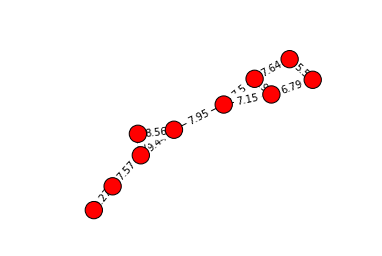

In [398]:
def GraphGenerator(e,eProb,minw,maxw):
    G = NX.erdos_renyi_graph(e, eProb)
    diff = maxw-minw
    for i in G.edges():
        G[i[0]][i[1]]['weight'] = round((np.random.random()*diff)+minw,2) #Random float from range(min,max), rounded to 2 d.p.
#     print G.edge
    return G

def DrawGraph(graph):
    pos = NX.spring_layout(graph)
    edge_labels=dict([((u,v,),d['weight']) #Label the edges to show 
    for u,v,d in graph.edges(data=True)])
    NX.draw_networkx_edge_labels(graph,pos,edge_labels=edge_labels) #Draw Edges
    NX.draw(graph,pos) #Draw actual graph
    plt.show()
    
myGraph = graphGenerator(10,0.3,5.0,11.0)
# You have to specify how many nodes you want, the probability of there being an edge
# between nodes, and min-max range you want the weights to be in.
drawGraph(myGraph)

I wanted to explore the different ways to generate adjacency matrices to represent the edges in my test graphs. I chose the undirected matrix with defined probability (of there being an edge between 2 nodes).

In [399]:
def GenDirMatrix(n):
    G = np.random.randint(0, 2, n**2).reshape(n, n)
    return G

def GenUndirMatrix(n):
    G = np.empty(n**2,dtype=int).reshape(n, n)
    for i in range(n):
        for j in range(i+1):
            G[i,j] = np.random.randint(0, 2)
    for i in range(n):
        for j in range(i,n):
            G[i,j] = G[j,i]
    return G

def PGenDirMatrix(n,p):
    G = np.empty(n**2,dtype=int)
    for k in range(n**2):
        if (np.random.random()<=p): G[k] = 1
        else: G[k] = 0
    G = G.reshape(n, n)
    return G

def PGenUndirMatrix(n,p):
    G = np.empty(n**2,dtype=int).reshape(n, n)
    for i in range(n):
        for j in range(i+1):
            if (np.random.random()<=p): G[i,j] = 1
            else: G[i,j] = 0
    for i in range(n):
        for j in range(i,n):
            G[i,j] = G[j,i]
    return G

print GenDirMatrix(5)
print "============="
print GenUndirMatrix(5)
print "============="
print PGenDirMatrix(5,0.3)
print "============="
print PGenUndirMatrix(5,0.3)

[[0 1 1 1 0]
 [0 0 1 0 0]
 [1 1 1 0 1]
 [1 0 0 1 1]
 [0 1 1 1 1]]
[[1 1 0 1 0]
 [1 1 1 1 1]
 [0 1 1 0 1]
 [1 1 0 0 0]
 [0 1 1 0 0]]
[[0 1 0 1 0]
 [1 0 0 0 0]
 [0 1 0 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]
[[1 0 1 0 0]
 [0 1 0 0 1]
 [1 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 1]]


Below is an example of how a random graph would look like without my Spring Embedded algorithm (with the random probability, you usually get an 'ugly' graph).

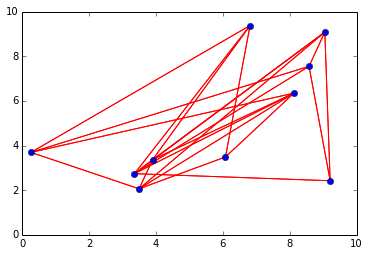

In [421]:
def PlotGraph(G,xi,yi):
    lg = len(xi)
    for i in range(lg):
        for j in range(lg): 
            if (G[i,j]==1):
                plt.plot([xi[i],xi[j]],[yi[i],yi[j]],'r')
    for k in range(lg):
        plt.plot(xi[k],yi[k],'ob')

def RandomPlot(G,xdim,ydim):
    plt.xlim(0,xdim)
    plt.ylim(0,ydim)
    
    lg = len(G)
    xi = np.random.random(lg)*xdim
    yi = np.random.random(lg)*ydim
    return xi, yi

A = PGenUndirMatrix(10,0.5)
xa,ya = RandomPlot(A,10.,10.)
PlotGraph(A,xa,ya)

For testing purposes, I also included a seeded function so that it's easier to see the difference with and without Spring Embedding.

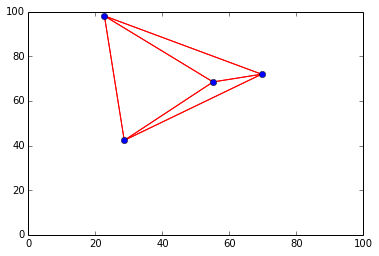

In [401]:
def PlotGraph(G,xi,yi):
    lg = len(xi)
    for i in range(lg):
        for j in range(lg): 
            if (G[i,j]==1):
                plt.plot([xi[i],xi[j]],[yi[i],yi[j]],'r')
    for k in range(lg):
        plt.plot(xi[k],yi[k],'ob')

def RandomSeededPlot(G,sd=None,xdim=100.0,ydim=100.0):
    plt.xlim(0,xdim)
    plt.ylim(0,ydim)
    
    lg = len(G)
    if (sd!=None):
        np.random.seed(sd)
    xi = np.random.random(lg)*xdim
    yi = np.random.random(lg)*ydim
    return xi, yi

def PGenUndirMatrix(n,p):
    G = np.empty(n**2,dtype=int).reshape(n, n)
    for i in range(n):
        for j in range(i+1):
            if (np.random.random()<=p): G[i,j] = 1
            else: G[i,j] = 0
    for i in range(n):
        for j in range(i,n):
            G[i,j] = G[j,i]
    return G

A = PGenUndirMatrix(4,1.0)
xa,ya = RandomSeededPlot(A,123)
PlotGraph(A,xa,ya)

For the next bit, I included the functions to calculate the Euclid Distance between two nodes (just the difference between them within the graph - which we'll try to minimize), and also the all-pairs shortest path (Floyd Warshall) algorithm (which will calculate the shortest distance to get between two nodes through the edges, and give an infinite value if it cannot reach the node through any edges).

In [402]:
def PlotGraph(G,xi,yi):
    lg = len(xi)
    for i in range(lg):
        for j in range(lg): 
            if (G[i,j]==1):
                plt.plot([xi[i],xi[j]],[yi[i],yi[j]],'r')
    for k in range(lg):
        plt.plot(xi[k],yi[k],'ob')

def EuclidDistance(G,xi,yi):
    lg = len(xi)
    D = np.empty(lg**2).reshape(lg, lg)
    for m in range(lg):
        for n in range(lg):
            if (m==n):
                continue
            D[m,n] = np.sqrt((xi[m]-xi[n])**2+(yi[m]-yi[n])**2)
            D[n,m] = D[m,n]
    return D

def EdgeInitiation(G,D):
    lg = len(G)
    E = np.empty(lg**2).reshape(lg, lg)
    for m in range(lg):
        for n in range(lg):
            if (m==n):
                continue
            if (G[m,n]==1):
                E[m,n] = D[m,n]
                E[n,m] = D[m,n]
            else:
                E[m,n] = float("inf")
                E[n,m] = float("inf")
    return E

def FloydWarshall(E,lg):
    for k in range(lg):
        for i in range(lg):
            for j in range(lg):
                if (i==j):
                    continue
                E[i,j] = min(E[i,j], E[i,k]+E[k,j])
    return E

D = EuclidDistance(A,xa,ya)
E1 = EdgeInitiation(A,D)
E = FloydWarshall(E1,len(A))
print D
print "============="
print E

[[  3.10503618e+231   5.06163337e+001   5.37416050e+001   1.49230295e+001]
 [  5.06163337e+001   2.25690151e-314   5.60800505e+001   3.72581649e+001]
 [  5.37416050e+001   5.60800505e+001   2.22274012e-314   4.39151053e+001]
 [  1.49230295e+001   3.72581649e+001   4.39151053e+001   1.11253915e-308]]
[[  3.10503618e+231   5.06163337e+001   5.37416050e+001   1.49230295e+001]
 [  5.06163337e+001   6.92863031e-310   5.60800505e+001   3.72581649e+001]
 [  5.37416050e+001   5.60800505e+001   2.24716069e-314   4.39151053e+001]
 [  1.49230295e+001   3.72581649e+001   4.39151053e+001   1.11253693e-308]]


Here is the "main body" of my project, where I include the Spring Embedded graph function (whereby if you give it a matrix of edges, it will output a decent configuration of node positions so that the graph looks aesthetically pleasing). 

To this, we model the edges as springs (which try to minimize the tension in the spring/length of the edge) and make the nodes 'repel' each other (the closer they are, the stronger the repulsion. To see more detail on how this is done:-
> http://www.collectionscanada.gc.ca/obj/s4/f2/dsk3/ftp04/mq43368.pdf

Using this idea and concepts of Hill Climbing/Simulated Annealing, we come should come up with a cost function which should minimize the 'spring tension' of each edge and 'repulsion force' of each node. So, using the equation provided in the websites below (and a little bit of functional programming), I came up with the cost function shown below.
> http://reference.wolfram.com/language/tutorial/GraphDrawingIntroduction.html#194525651

> http://emr.cs.iit.edu/~reingold/force-directed.pdf

I also created update functions for both Euclid distance and Floyd Warshall so that it gives better performance instead of having to go through all the edges again.

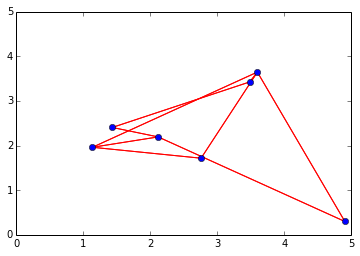

In [403]:
def PlotGraph(G,xi,yi,xdim=5.0,ydim=5.0):
    lg = len(xi)
    for i in range(lg):
        for j in range(lg): 
            if (G[i,j]==1):
                plt.plot([xi[i],xi[j]],[yi[i],yi[j]],'r')
    for k in range(lg):
        plt.plot(xi[k],yi[k],'ob')
    plt.xlim(0.0,xdim)
    plt.ylim(0.0,ydim)

def PGenUndirMatrix(n,p,sd=None):
    G = np.empty(n**2,dtype=int).reshape(n, n)
    if (sd!=None):
        np.random.seed(sd)
    for i in range(n):
        for j in range(i+1):
            if (np.random.random()<=p): G[i,j] = 1
            else: G[i,j] = 0
    for i in range(n):
        for j in range(i,n):
            G[i,j] = G[j,i]
    return G
        
def RandomSeededPlot(G,sd=None,xdim=5.0,ydim=5.0):
    plt.xlim(0,xdim)
    plt.ylim(0,ydim)
    
    lg = len(G)
    if (sd!=None):
        np.random.seed(sd)
    xi = np.random.random(lg)*xdim
    yi = np.random.random(lg)*ydim
    return xi, yi

def EuclidDistance(G,xi,yi):
    lg = len(xi)
    D = np.empty(lg**2).reshape(lg, lg)
    for m in range(lg):
        for n in range(lg):
            if (m==n):
                continue
            D[m,n] = np.sqrt((xi[m]-xi[n])**2+(yi[m]-yi[n])**2)
            D[n,m] = D[m,n]
    return D

def EuclidUpdate(Dp,p,xi,yi):
    D = np.copy(Dp)
    for n in range(len(xi)):
        if (n==p):
            continue
        D[p,n] = np.sqrt((xi[p]-xi[n])**2+(yi[p]-yi[n])**2)
        D[n,p] = D[p,n]
    return D

def EdgeInitiation(G,D,maxv):
    lg = len(G)
    E = np.empty(lg**2).reshape(lg, lg)
    for m in range(lg):
        for n in range(lg):
            if (m==n):
                continue
            if (G[m,n]==1):
                E[m,n] = D[m,n]
                E[n,m] = D[m,n]
            else:
                E[m,n] = maxv
                E[n,m] = maxv
    return E

def EdgeUpdate(G,Ep,D,p):
    E = np.copy(Ep)
    for n in range(len(G)):
        if (n==p):
            continue
        if (G[p,n]==1):
            E[p,n] = D[p,n]
            E[n,p] = D[p,n]
    return E

def FloydWarshall(E,lg):
    for k in range(lg):
        for i in range(lg):
            for j in range(lg):
                if (i==j):
                    continue
                E[i,j] = min(E[i,j], E[i,k]+E[k,j])
    return E

def MakeCostFunction(A,xi,yi,p,xdim=5.0,ydim=5.0):
    xp = xi[p]
    yp = yi[p]
    lg = len(xi)
    R = 1.0
    D = EuclidDistance(A,xi,yi)
    E1 = EdgeInitiation(A,D,xdim)
    
    def Cost(v):
        x,y = v
        xt = np.copy(xi)
        xt[p] = x
        yt = np.copy(yi)
        yt[p] = y
        
        Dt = EuclidUpdate(D,p,xt,yt)
        Et = EdgeUpdate(A,E1,Dt,p)
        E = FloydWarshall(Et,lg)
        
        out = 0.0
        for i in range(len(xi)-1):
            for j in range(i+1,len(xi)):
                Lij = E[i,j]
                d = Dt[i,j]**2
                res = (d-Lij)**2
                res *= R/(Lij**2)
                out += res
        return out
    return Cost
        
def SpringEmbeddedGraph(G,xi,yi,n,xdim=5.0,ydim=5.0):
    for i in range(n):
        p = np.random.randint(0, len(xi))
        cost = MakeCostFunction(G,xi,yi,p,xdim,ydim)
        start = [np.random.random()*xdim,np.random.random()*ydim]
#         print cost(start)
        bnds = [[0.0, xdim], [0.0, ydim]]
        res = scipy.optimize.minimize(cost,start,bounds=bnds)
        xi[p] = res.x[0]
        yi[p] = res.x[1]
    return xi,yi

xdim = 5.0
ydim = 5.0
A = PGenUndirMatrix(7,0.5,123)
xa,ya = RandomSeededPlot(A,123,xdim,ydim)
PlotGraph(A,xa,ya,xdim,ydim)
# xb,yb = SpringEmbeddedGraph(A,xa,ya,100,xdim,ydim)
# PlotGraph(A,xb,yb)

Above, you see an example with just a random plot, and below you can see one with my Spring Embedding function (hopefully more aesthetically pleasing!). With aesthetics, there is no right or wrong answer, so it's impossible to prove that my answer is a success, but you can kind of see and appreciate the difference.

The rest of the notebook just shows more examples of the my test graphs before and after running through my algorithm. Also, since my function works with the concept of randomness, you are highly unlikely to get two identical drawings of the graph when you run my algorithm (unless you implicitly declare a seed).

/Library/Python/2.7/site-packages/ipykernel/__main__.py:114: RuntimeWarning: overflow encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:115: RuntimeWarning: overflow encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:115: RuntimeWarning: invalid value encountered in double_scalars


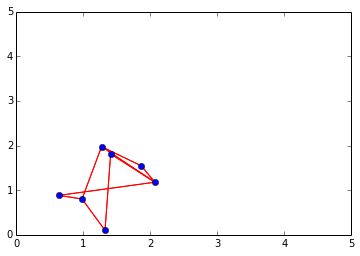

In [420]:
xdim = 5.0
ydim = 5.0
A = PGenUndirMatrix(7,0.5,123)
xa,ya = RandomSeededPlot(A,123,xdim,ydim)
xb,yb = SpringEmbeddedGraph(A,xa,ya,100,xdim,ydim)
PlotGraph(A,xa,ya,xdim,ydim)

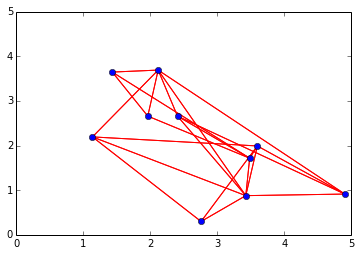

In [405]:
xdim = 5.0
ydim = 5.0
A = PGenUndirMatrix(10,0.5,123)
xa,ya = RandomSeededPlot(A,123,xdim,ydim)
PlotGraph(A,xa,ya)

Below is one of the more nicer looking representations!

/Library/Python/2.7/site-packages/ipykernel/__main__.py:114: RuntimeWarning: overflow encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:115: RuntimeWarning: overflow encountered in double_scalars
/Library/Python/2.7/site-packages/ipykernel/__main__.py:115: RuntimeWarning: invalid value encountered in double_scalars


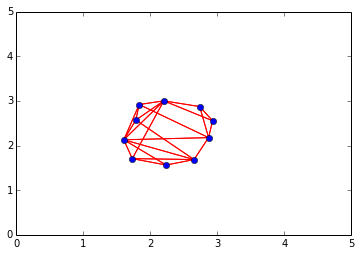

In [410]:
xdim = 5.0
ydim = 5.0
A = PGenUndirMatrix(10,0.5,123)
xa,ya = RandomSeededPlot(A,123,xdim,ydim)
xb,yb = SpringEmbeddedGraph(A,xa,ya,100,xdim,ydim)
PlotGraph(A,xb,yb)

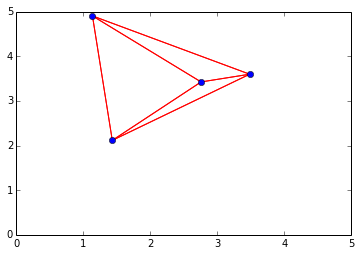

In [407]:
xdim = 5.0
ydim = 5.0
A = PGenUndirMatrix(4,1.0,123)
xa,ya = RandomSeededPlot(A,123,xdim,ydim)
PlotGraph(A,xa,ya)

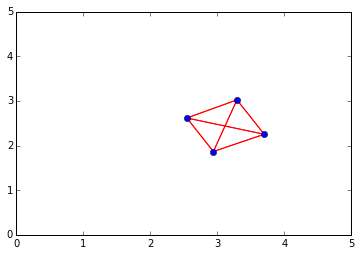

In [418]:
xdim = 5.0
ydim = 5.0
A = PGenUndirMatrix(4,1.0,123)
xa,ya = RandomSeededPlot(A,123,xdim,ydim)
xb,yb = SpringEmbeddedGraph(A,xa,ya,100,xdim,ydim)
PlotGraph(A,xb,yb)

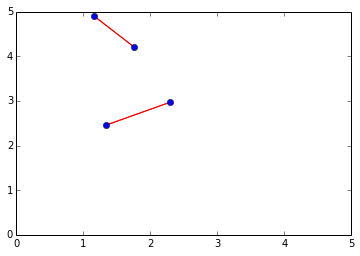

In [415]:
xdim = 5.0
ydim = 5.0
A = PGenUndirMatrix(4,0.5,123)
xa,ya = RandomSeededPlot(A,123,xdim,ydim)
xb,yb = SpringEmbeddedGraph(A,xa,ya,10,xdim,ydim)
PlotGraph(A,xb,yb)